<a href="https://colab.research.google.com/github/cauchymike/Hamoye_project_1/blob/master/market_square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## importing neccessary libraries
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import holidays
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
##reading the data into pandas
url_test = "https://raw.githubusercontent.com/cauchymike/data_save_1/main/test.csv"
url_train = "https://raw.githubusercontent.com/cauchymike/data_save_1/main/train.csv"
df_train = pd.read_csv(url_train, parse_dates=['date'])
df_test = pd.read_csv(url_test, parse_dates=['date'])

In [9]:
#define a function to get a quick glance at our data
def check_df(dataframe):
    print("##################### Shape of dataframe#####################")
    print(dataframe.shape)
    print("##################### Types of data in each column #####################")
    print(dataframe.dtypes)
    print("##################### Head data #####################")
    print(dataframe.head(5))
    print("##################### Tail data #####################")
    print(dataframe.tail(5))
    print("##################### Sum of Null values in each column #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [10]:
#quick analysis of the dataframes
check_df(df_train)

##################### Shape of dataframe#####################
(913000, 4)
##################### Types of data in each column #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head data #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-02-01      1     1     11
2 2013-03-01      1     1     14
3 2013-04-01      1     1     13
4 2013-05-01      1     1     10
##################### Tail data #####################
             date  store  item  sales
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### Sum of Null values in each column #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0

###### Quick analysis


The date column will be used to build our model, we will extract information from this column. As we can see, there are no missing values in the columns for this data. For sales, we can see that for the 50th percentile The number of sales at the 47th position shows data that fall below and above 50% of the data.


Now lets check for outliers. Outliers can confuse the model.

In [12]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [13]:
#these are the thresholds for our number of sales... any number of sales for a particular day greater than or less than these
#values will be considered outliers and looked into
outlier_thresholds(df_train, "sales")

(-120.5, 243.5)

In [14]:
#now lets see if the data actually contains outliers
#we are using Q1 as 0.05% and Q3 as 0.95%.
check_outlier(df_train, "sales")

#from the below output, there are no outliers in the number of sales for each day

False

<Figure size 432x288 with 0 Axes>

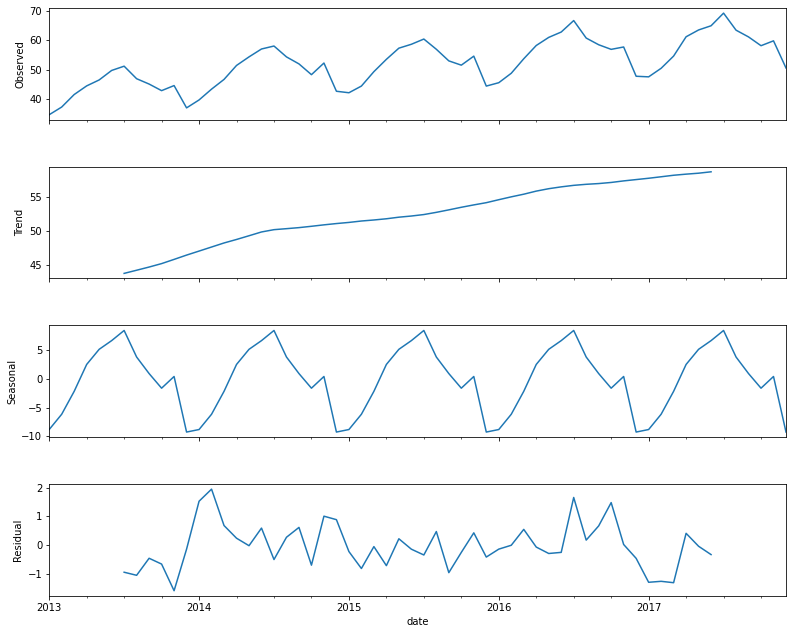

In [15]:
#brief visualization
train_plot = df_train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 10)

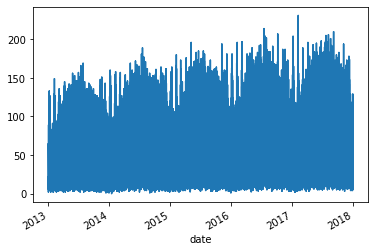

In [16]:
df_train_1 = df_train.set_index("date")
df_train_1['sales'].plot()

<BarContainer object of 60 artists>

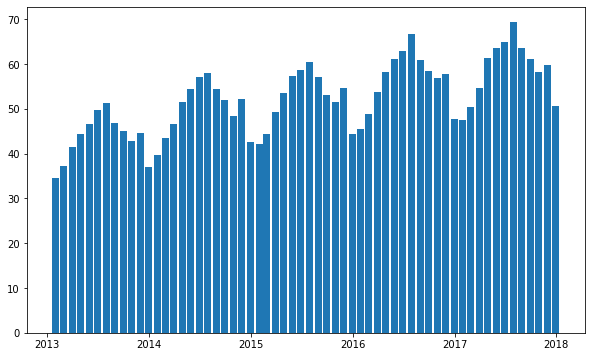

In [17]:
df_month = df_train_1.resample("M").mean()
fig, ax = plt.subplots(figsize=(10, 6))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.bar(df_month['2013':].index, df_month.loc['2013':, "sales"], width=25, align='center')

In [18]:
#in the figure above, each bar represents a month... highest sale came from 2017 nov... there seems to be no monthly seasonality
#lets get more visualization
df_week = df_train_1.resample("W").mean()



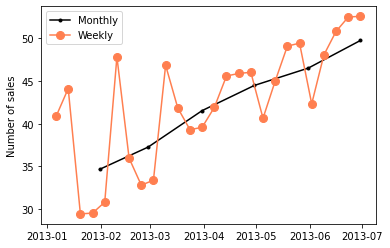

In [19]:
#for 2013 weekly and monthly.... ZOOMING IN TECHNIQUE
start, end = '2013-01', '2013-06'
fig, ax = plt.subplots()


ax.plot(df_month.loc[start:end, 'sales'], marker='.', linestyle='-', linewidth = 1.5, label='Monthly', color='black')
ax.plot(df_week.loc[start:end, 'sales'], marker='o', markersize=8, linestyle='-',linewidth = 1.5, label='Weekly', color='coral')

ax.set_ylabel("Number of sales")
ax.legend()

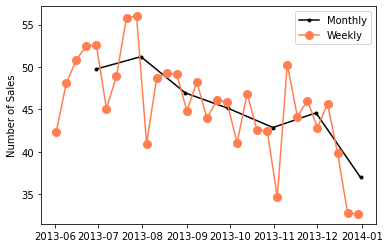

In [ ]:
start, end = '2013-06', '2013-12'
fig, ax = plt.subplots()


ax.plot(df_month.loc[start:end, 'sales'], marker='.', linestyle='-', linewidth = 1.5, label='Monthly', color='black')
ax.plot(df_week.loc[start:end, 'sales'], marker='o', markersize=8, linestyle='-',linewidth = 1.5, label='Weekly', color='coral')

ax.set_ylabel("Number of Sales")
ax.legend()

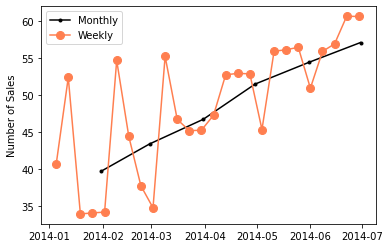

In [ ]:
#for 2014 weekly and monthly.... ZOOMING IN TECHNIQUE
start, end = '2014-01', '2014-06'
fig, ax = plt.subplots()


ax.plot(df_month.loc[start:end, 'sales'], marker='.', linestyle='-', linewidth = 1.5, label='Monthly', color='black')
ax.plot(df_week.loc[start:end, 'sales'], marker='o', markersize=8, linestyle='-',linewidth = 1.5, label='Weekly', color='coral')

ax.set_ylabel("Number of Sales")
ax.legend()

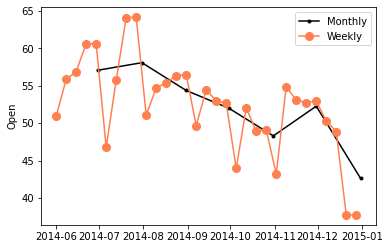

In [ ]:
start, end = '2014-06', '2014-12'
fig, ax = plt.subplots()


ax.plot(df_month.loc[start:end, 'sales'], marker='.', linestyle='-', linewidth = 1.5, label='Monthly', color='black')
ax.plot(df_week.loc[start:end, 'sales'], marker='o', markersize=8, linestyle='-',linewidth = 1.5, label='Weekly', color='coral')

ax.set_ylabel("Open")
ax.legend()

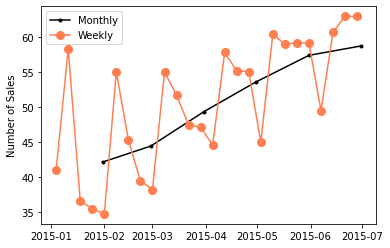

In [ ]:
start, end = '2015-01', '2015-06'
fig, ax = plt.subplots()


ax.plot(df_month.loc[start:end, 'sales'], marker='.', linestyle='-', linewidth = 1.5, label='Monthly', color='black')
ax.plot(df_week.loc[start:end, 'sales'], marker='o', markersize=8, linestyle='-',linewidth = 1.5, label='Weekly', color='coral')

ax.set_ylabel("Number of Sales")
ax.legend()

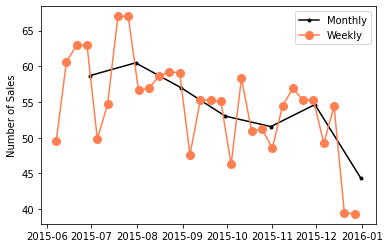

In [ ]:
start, end = '2015-06', '2015-12'
fig, ax = plt.subplots()


ax.plot(df_month.loc[start:end, 'sales'], marker='.', linestyle='-', linewidth = 1.5, label='Monthly', color='black')
ax.plot(df_week.loc[start:end, 'sales'], marker='o', markersize=8, linestyle='-',linewidth = 1.5, label='Weekly', color='coral')

ax.set_ylabel("Number of Sales")
ax.legend()

###### We could have applied rolling, but we did not notice very large spikes in the data. Although, there is a very visible pattern in the dataset

##### One of the reason why we are exploring our data is to understand the past behaviour of our data, this will help us detect the accuracy of our model

## FEATURE ENGINEERING


Here, we will create new features, this will include lag_features, window features and expanding windows 

In [20]:
def create_date_features(df):
    #we wont need these variables if our data only contains information about the month
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.date.dt.strftime("%A")
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df